In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from flash_ansr import FlashANSR, get_path, FlashANSRTransformer, ExpressionSpace
from flash_ansr.expressions.utils import codify, num_to_constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = 'v5.1'
# CHECKPOINT = 'checkpoint_300000'
CHECKPOINT = ''

In [4]:
nsr = FlashANSR(
    expression_space=ExpressionSpace.from_config(get_path('models', 'ansr-models', MODEL, CHECKPOINT, 'expression_space.yaml')),
    nsr_transformer=FlashANSRTransformer.load(get_path('models', 'ansr-models', MODEL, CHECKPOINT))[1].to(device).eval(),
    n_beams=32,
    n_restarts=4,
    verbose=True,
    numeric_head=False
)

nsr.nsr_transformer.to(device).eval()

print(f'{nsr.nsr_transformer.n_params:,} parameters')

27,109,410 parameters


In [5]:
demo_expressions = [
    ('x**2', None, (-5, 5)),
    ('sin(x)', None, (-5, 5)),
    ('-x + log(x + x**4)', None, (1, 5)),
    ('x1**2 + 2*x1 + 1', (2, 1), (1, 5)),
    ('exp(- x**2)', None, (-5, 5)),
    ('x**3 + 2*x**2 + 1', (2, 1), (-5, 5)),
    ('exp(- (x - 3.4)**2)', (3.4,), (-5, 5)),
    ('exp(- (x - 1.4)**2 / 4.3)', (1.4, 4.3), (-5, 5)),
    ('cos(3.3 * x) * exp(-x * 0.5)', (3.3, 0.5,), (0, 5)),
    ('1.2', (1.2,), (-5, 5)),
    ('sin(tan(x))', None, (-5, 5)),
    ('asin((sin(x1) / x1))', None, (-10, 10)),
]

expression, constants, xlim = demo_expressions[-1]

prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
code = codify(code_string, nsr.expression_space.variables + constants_names)

if constants is None:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
else:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

In [6]:
x = np.random.uniform(*xlim, 128)

y = demo_function(x)

if isinstance(y, float):
    y = np.full_like(x, y)

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(-1).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

pad_length = nsr.nsr_transformer.encoder_max_n_variables - x_tensor.shape[1] - y_tensor.shape[1]
x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0), value=0)

print(x_tensor.shape, y_tensor.shape)

torch.Size([128, 3]) torch.Size([128, 1])


(-0.1, 1.5)

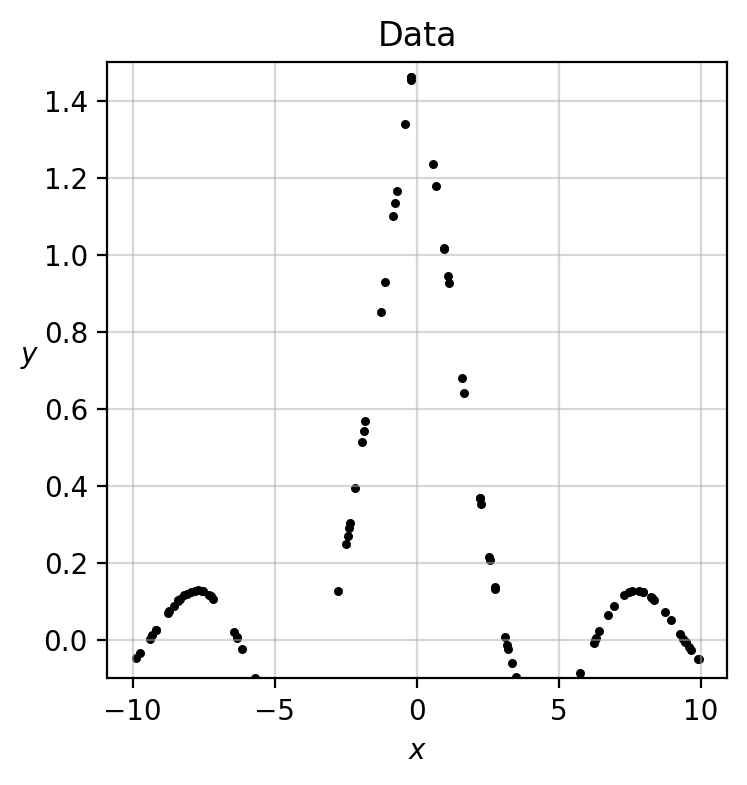

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)

ax.scatter(x, y, label=f'f(x) = {expression}', color='k', s=5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$', rotation=0, labelpad=5)
# ax.legend()
ax.grid(alpha=0.5)
ax.set_title('Data')
ax.set_ylim(-0.1, 1.5)

In [8]:
x_linspace = np.linspace(xlim[0] - 0.5, xlim[1] + 0.5, 1000)

x_linspace_tensor = torch.tensor(x_linspace, dtype=torch.float32).unsqueeze(-1).to(device)
x_linspace_tensor = nn.functional.pad(x_linspace_tensor, (0, pad_length, 0, 0), value=0)

In [9]:
nsr.max_len = 32

In [10]:
nsr.fit(x_tensor, y_tensor)

FlashANSR(expression_space=<flash_ansr.expressions.expression_space.ExpressionSpace object at 0x7fb9bfce8990>,
          n_beams=32, n_restarts=4,
          nsr_transformer=FlashANSRTransformer(
  (pre_encoder): PreEncoder()
  (encoder): SetTransformer(
    (enc): Sequential(
      (0): ISAB(
        (mab0): MAB(
          (W_q): Linear(in_features=512, out_features=512, bias=True)
          (W_k): Linear(in_features=64, out_featur...
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=33, bias=True)
  )
  (num_out): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
),
          verbose=True)

In [10]:
y_pred = [[nsr.predict(x_tensor.cpu(), nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result[1]['fits']))] for beam_id, result in enumerate(nsr._results)]
y_pred_linspace = [[nsr.predict(x_linspace_tensor.cpu(), nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result[1]['fits']))] for beam_id, result in enumerate(nsr._results)]

<lambdifygenerated-1732111197972174178:1: RuntimeWarning: invalid value encountered in sin


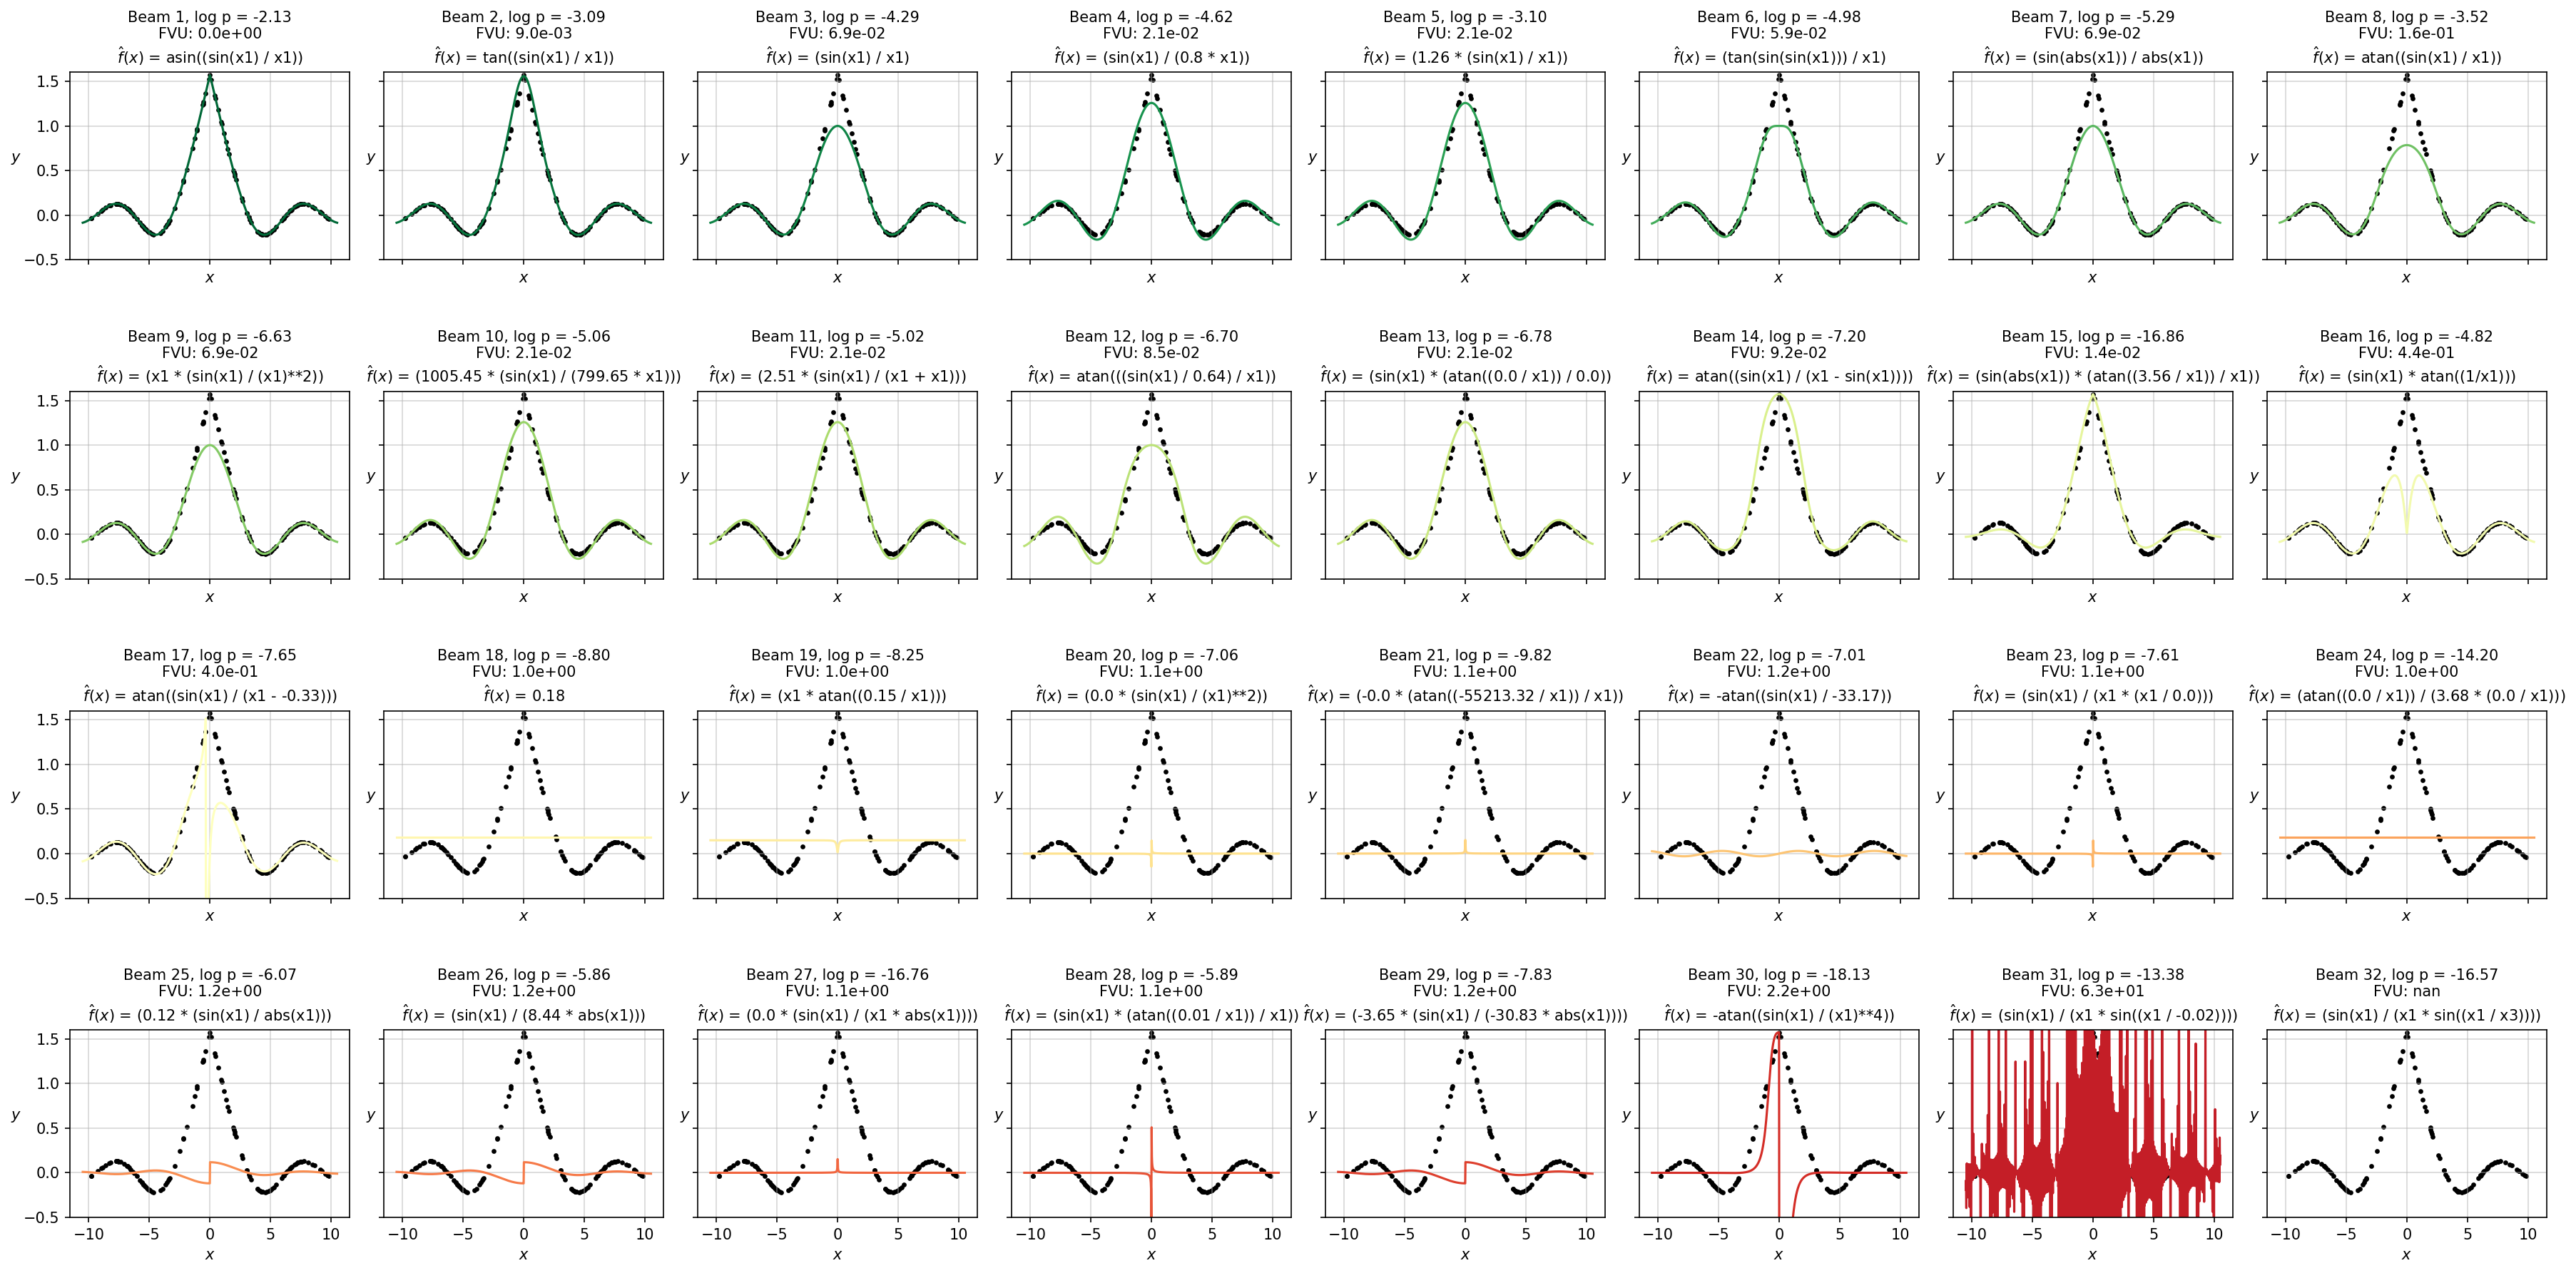

In [14]:
COLS = 8
ROWS = np.ceil(len(y_pred) / COLS).astype(int)

fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 3), dpi=150, sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    if i >= len(y_pred):
        ax.axis('off')
        continue
    fvu = np.mean((y_pred[i][0][:, 0] - demo_function(x.astype(np.float32)))**2) / np.var(demo_function(x.astype(np.float32)))
    expression_pred_transformed = nsr._results[i][0].transform(nsr._results[i][1]['expression'], 0, return_prefix=True)
    expression_pred_transformed_infix = nsr.expression_space.prefix_to_infix(expression_pred_transformed, power='**')

    ax.plot(x_linspace, y_pred_linspace[i][0], color=plt.get_cmap('RdYlGn')(1 - i / len(y_pred)))
    ax.scatter(x, y, color='k', s=5)
    ax.set_title(f'Beam {i + 1}, log p = {nsr._results[i][1]["log_prob"]:.2f}\nFVU: {fvu:.1e}\n$\\hat f(x)$ = {expression_pred_transformed_infix}', fontsize=10)
    ax.set_ylim(-0.5, 1.6)
    ax.grid(alpha=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$', rotation=0, labelpad=5)

fig.tight_layout(h_pad=3)

In [11]:
expression_pred = nsr._results[0]['expression']
expression_pred_transformed = nsr.refiner.transform(expression_pred, 0, return_prefix=True)
expression_pred_transformed_infix = nsr.expression_space.prefix_to_infix(expression_pred_transformed, power='**')

In [54]:
mse = nsr._results[0]['fits'][0][-1]
fvu = np.mean((y_pred[:, 0] - demo_function(x.astype(np.float32)))**2) / np.var(demo_function(x.astype(np.float32)))

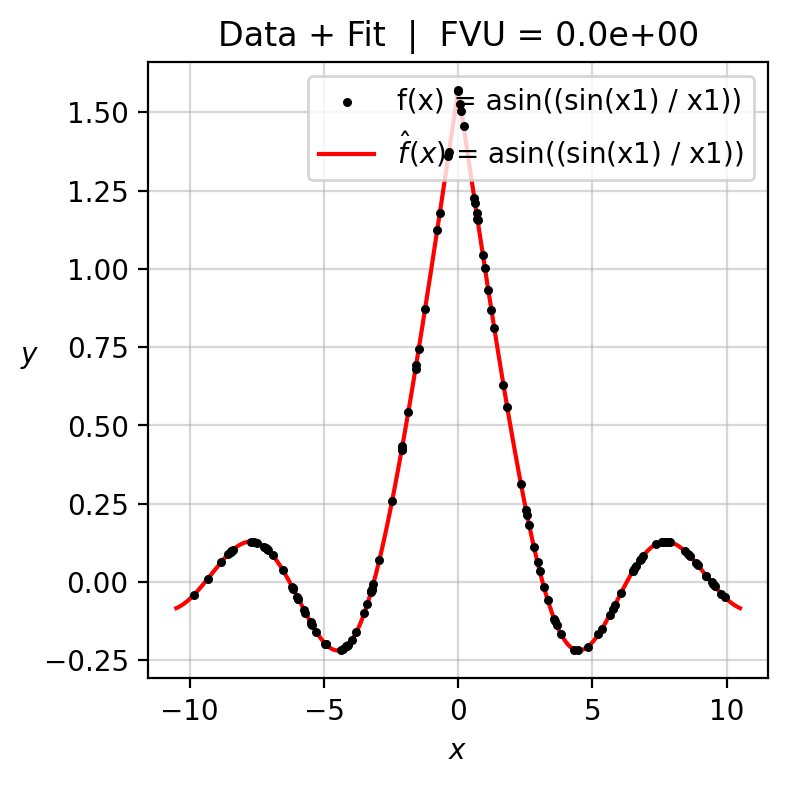

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)

ax.scatter(x, y, label=f'f(x) = {expression}', color='k', s=5, zorder=10)
ax.plot(x_linspace, y_pred_linspace, label=r'$\hat f(x)$ = ' + expression_pred_transformed_infix, color='r')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$', rotation=0, labelpad=5)
ax.legend()
# ax.set_title(f'Data + Fit  |  MSE = {mse:.1e}')
ax.set_title(f'Data + Fit  |  FVU = {fvu:.1e}')
# ax.set_title(f'Data + Fit')
ax.grid(alpha=0.5)
# ax.set_ylim(-0.1, 1.5)

In [46]:
nsr._results

[{'numeric_prediction': None,
  'beam': [1, 11, 23, 10, 6, 30, 7, 30, 6, 2],
  'expression': ['/', 'cos', '*', '<num>', 'x1', '+', 'x1', '<num>'],
  'lambda': <function nsr.expressions.expression_space.<lambda>(x1, x2, x3, C_0, C_1)>,
  'fits': [(array([3.29844477, 0.9328235 ]),
    array([[ 6.28703086e-05, -1.74262151e-06],
           [-1.74262151e-06,  2.26374718e-04]]),
    0.0017958243),
   (array([-3.29844189,  0.93282356]),
    array([[6.28702196e-05, 1.74254581e-06],
           [1.74254581e-06, 2.26374747e-04]]),
    0.001795825),
   (array([-1.79154516,  2.02671221]),
    array([[0.00436816, 0.00057123],
           [0.00057123, 0.14575356]]),
    0.08993915),
   (array([-1.79153676,  2.02673158]),
    array([[0.00436818, 0.0005713 ],
           [0.0005713 , 0.14575975]]),
    0.08993915),
   (array([-1.79156877,  2.02665881]),
    array([[0.00436811, 0.00057104],
           [0.00057104, 0.14573668]]),
    0.089939155),
   (array([8.13724416, 9.11227761]),
    array([[ 0.0292879